# Word2Vec
[https://web.stanford.edu/~jurafsky/slp3/6.pdf](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

In [ ]:
import numpy as np
from collections import defaultdict
import random
from IPython.display import clear_output

In [ ]:
import re
with open('../data/facundo.txt','r') as f:
  corpus = f.read()
corpus = re.sub(r'(?<!\n)\n(?!\n)',' ', corpus)
corpus = corpus.lower()
corpus = re.sub(r'("|,|:|;|_|\n|\*|(|)|«|»)','',corpus)
corpus = corpus.split('.')

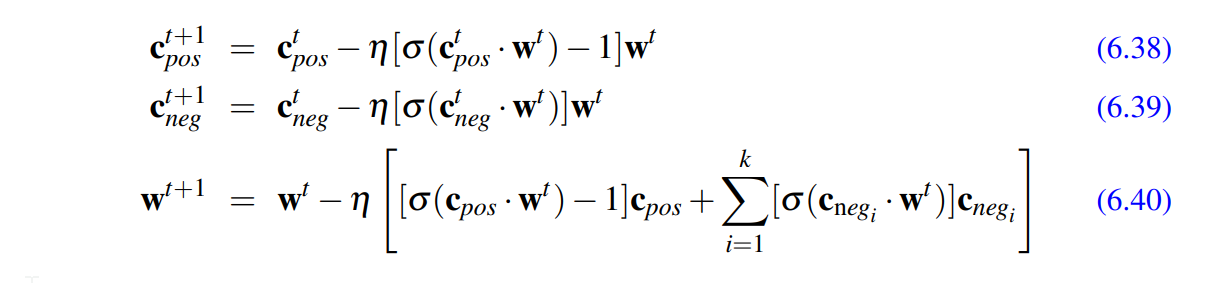

In [ ]:
def normalize(string):
    return string.strip().lower()

In [ ]:
DEBUG = True
def debug_print(*args,**kwargs):
  if DEBUG:
    print(*args,**kwargs)

In [ ]:
class Word2Vec:
    def __init__(self, context_window=2, num_dimensions=5, num_negative_samples=2,normalizer_func=None):
        self.num_dimensions = num_dimensions
        self.context_window = context_window
        self.num_negative_samples = num_negative_samples*context_window
        self.normalize = normalizer_func
        self.W = None
        self.V = None

    def train(self, corpus, learning_rate=0.1, decay_rate=0.1, num_epochs=100):
        """
        (1) Crea el vocabulario a partir del corpus
        (2) Inicializa la matriz de weights
        (3) Itera sobre el número de epochs (q veces que se va a repetir el mismo proceso)
        (4) Actualiza los pesos por cada ejemplo de entrenamiento (consistente en la palabra target, lista de palabras contexto, lista de negative samples)
        (5) Suma las dos matrices entrenadas
        """
        self.losses = list() # Lista para guardar el valor de la función costo en cada epoch. Es puramente informativo
                        # ¿Habría una forma más prolija de setear esto?
        self.count = 0
        self.last_print = ''
        self.num_epochs = num_epochs

        self.build_vocabulary(corpus)
        self.initialize_weights()

        for epoch in range(self.num_epochs):
            self.total_loss = 0.0 # Informativo
            learning_rate = self.get_learning_rate(learning_rate=learning_rate)
            for target, context, negative_samples in self.generate_training_data(corpus):
                self.update_weights(target, context, negative_samples, learning_rate)
            self.losses.append(self.total_loss)
            print(f"Loss at epoch {epoch}: {self.total_loss}")

        self.W += self.V

    def build_vocabulary(self, corpus):
      """
      Crea una lista de palabras únicas, cuya posición es su idx
      """
      self.vocabulary = set()
      for sentence in corpus:
          for word in sentence.split():
            self.vocabulary.add(word)
      self.vocabulary = list(self.vocabulary)

    def initialize_weights(self):
        """
        Crea dos matrices W (target words) y V (context words) de dimensiones vocab_size * ndims
        El valor de cada dimensión se elige al azar dentro de un rango de [-0.5/ndims,0.5/ndims]. Parece ser práctica habitual
        """
        vocab_size = len(self.vocabulary)
        self.W = np.random.uniform(low=-0.5, high=0.5, size=(vocab_size, self.num_dimensions))
        self.V = np.zeros((vocab_size, self.num_dimensions))

    def generate_training_data(self, corpus):
        """
        Convierte cada oración del corpus en una lista de palabras ordenadas y devuelve la palabra target, las palabras context y los negative_samples
        """
        for sentence in corpus:
            self.print_progress(len(corpus)*self.num_epochs)
            sentence_list = sentence.strip().split()
            for target_idx, target in enumerate(sentence_list):
                context = self.get_context(sentence_list, target_idx)
                negative_samples = self.get_negative_samples(context)
                #print(f'target:{target} - context:{context} - negative_samples: {negative_samples}')
                yield target, context, negative_samples

    def get_context(self, sentence, target_idx):
      """
      Toma una lista de palabras (sentence) y el idx dentro de esa lista de la palabra target
      Devuelve una lista de palabras contexto
      """
      context = []
      for i in range(target_idx - self.context_window, target_idx + self.context_window + 1): # Ej: si la palabra target está en posición 5 de la oración, y context_window = 2, el rango es (3,7)
          if i != target_idx and i >= 0 and i < len(sentence): # Comprueba que haya una palabra con índice i en la oración (y no sea = a target)
              context.append(sentence[i])
      return context

    def get_negative_samples(self, context):
      """
      Selecciona palabras random del vocabulario que no estén entre las palabras contexto
      """
      negative_samples = []
      while len(negative_samples) < self.num_negative_samples:
          sample = random.choice(self.vocabulary)
          if sample not in context:
              negative_samples.append(sample)
      return negative_samples

    def update_weights(self, target, context, negative_samples, learning_rate):
      """
      Itera sobre las palabras contexto y los negative samples
      (1) Calcula el error
      (2) Lo suma a un atributo (que después se imprime en consola)
      (3) Actualiza la matriz de pesos
      """

      for context_word in context:
          debug_print(f'Target word: {target} - Context word: {context_word}')
          error = self.compute_error(target, context_word, 1) # 1 porque es la true label (context word)
          debug_print(f'Error: {abs(np.log(error+1.01))}')
          self.total_loss += abs(np.log(error+1.01))
          self.update_weights_for_word(target, context_word, error, learning_rate)

      for negative_word in negative_samples:
          debug_print(f'Target word: {target} - Negative sample: {negative_word}')
          error = self.compute_error(target, negative_word, 0) # 0 porque es la true label (negative sample)
          debug_print(f'Error: {abs(np.log(error+1.01))}')
          self.total_loss += abs(np.log(error+1.01))
          self.update_weights_for_word(target, negative_word, error, learning_rate)

    def compute_error(self, target, context_word, label):
        '''
        Con las context_words el true label es 1, y el algoritmo tiene que aproximar el producto punto (para que sean similares
        según el coseno); con las negative words el true label es 0, y el costo es mayor si la predicción se acerca a 1
        '''
        def sigmoid(x):
          return 1 / (1 + np.exp(-x))

        target_vector = self.W[self.vocabulary.index(target)]
        context_vector = self.V[self.vocabulary.index(context_word)]
        dot_product = np.dot(target_vector, context_vector) # producto punto, es mayor si los vectores se parecen
        prediction = sigmoid(dot_product) # probabilidad de coocurrencia rango [0-1]
        return prediction - label # da negativo para las context (p-1), y positivo para las negative (p-0). Podría ser al revés pero en Jurafsky es así

    def update_weights_for_word(self, target, word, error, learning_rate):
        """
        Actualiza los pesos según la ecuación de Jurfasky y Martin
        El gradiente es igual a error * w/v
        Si el error es negativo (context), los vectores se suman; caso contrario (negative sample) se restan
        Notemos que en este algoritmo la actualización se hace palabra por palabra, pero tal vez se podrían empaquetar todos los cálculos sumando los vectores de las context words y las negative words
        """
        debug_print(f'Target vector before update: {self.W[self.vocabulary.index(target)]}')
        self.W[self.vocabulary.index(target)] = self.W[self.vocabulary.index(target)] - learning_rate * error * self.V[self.vocabulary.index(word)]
        debug_print(f'Target vector after update: {self.W[self.vocabulary.index(target)]}')
        self.V[self.vocabulary.index(word)] = self.V[self.vocabulary.index(word)] - learning_rate * error * self.W[self.vocabulary.index(target)]
        debug_print(f'New error: {abs(np.log(self.compute_error(target,word,0)+1.01))}\n')

    def print_progress(self,len_corpus):
        self.count += 1
        trained = round((self.count/len_corpus)*100)
        if trained != self.last_print:
          clear_output(wait=True)
          print(f'{trained}% procesado',flush=True)
          self.last_print = trained

    def get_word_vector(self,word):
      if word in self.vocabulary:
        return self.W[self.vocabulary.index(word)].reshape(1,-1)
      else:
        print(f"{word} no está en el vocabulario.")

    def compute_most_similar_words(self, word, top_k=5):
        word_vector = self.get_word_vector(self.normalize(word))

        if word_vector is None:
            return []

        similarities = np.dot(self.W, word_vector.T)
        top_indices = np.argsort(similarities, axis=0)[::-1][:top_k]
        #return top_indices
        similar_words = [self.vocabulary[idx] for idx in top_indices.flatten() if idx != self.vocabulary.index(word)]
        return similar_words

    def get_learning_rate(self,learning_rate,min_value=0.0001):

      if len(self.losses) < 2:
        return learning_rate

      if self.losses[-1] < self.losses[-2]:
        return learning_rate
      if self.losses[-1] > self.losses[-2]:
        if learning_rate > min_value:
          learning_rate = learning_rate*0.5
          print(f'Adjusting learning rate. New value: {round(learning_rate,2)}')
          return learning_rate

      return learning_rate



In [ ]:
DEBUG = False
word2vec = Word2Vec(context_window=4, num_dimensions=100, num_negative_samples=2,normalizer_func = normalize)
word2vec.train(corpus[:100],num_epochs=40,learning_rate=0.5)

100% procesado
Loss at epoch 39: 39040.849042131485


# Comentario de un usuario de Stackoverflow al código
[https://stackoverflow.com/a/76706364/11731713](https://stackoverflow.com/a/76706364/11731713)

Some thoughts:

Until you're training with a corpus of many thousands of unique words, & with many varied usage contexts for every word-of-interest, & with vectors of higher dimensionality (at least 10s-of-dimensions), you won't be at the scale where word2vec provides value, and at the scale where variations of parameters/data/implementation-choices teach relevant/generalizable things about about word2vec.

That is, 'toy-sized' tests will often show nothing interesting, or mislead about the relevant decisions & tradeoffs. As the only scale-of-data you've mentioned is a mere "20 sentences", and you speak *favorably* of your loss results at that scale, you may simply be worrying about things that don't matter for word2vec's actual effectiveness.

In particular, word2vec model overall quality is generally *not* evaluable by checking the training loss. That's only appropriate for determining the point at which more training can't help, when the improvement-in-loss stagnates, hinting at 'model convergence' – as good as it can get at predicting the training data, within its size/parameter constraints.

(Further: typical open-source implementations like the original `word2vec.c` from Google, or the Python Gensim library, or Facebook's FastText release, don't even consult loss for that stopping decision, or even dynamic adjustment of the internal learning-rate. They instead traditionally just let users specify a fixed number of epochs, with straight-line decay of learning-rate. If training-loss is reported at all, it's only as advisory info for the operator, to guide comparisons to other runs.)

Whether a model's word-vectors – the neural-net's 'input weights' – are good at tasks is a separate matter than its internal training loss, and a model with higher final-epoch training-loss might yield better vectors for real purposes than a model with lower final-epoch training-loss.

In particular, a model that's far oversized for the training data may become incredibly good at predicting the idiosyncracies of the small training set – very low training loss – in ways that are deleterious for other out-of-training language modeling: overfitting.

So any concern that "this run's loss doesn't seem low enough" is likely misguided. Ask instead: when loss stagnated, were the word-vectors useful on robust repeatable evaluations, testing for the qualities your task(s) require?

From a quick glance at your code, some other comments:

* Your exploratory implementation has none of the common optimizations of usual implementations – most especially use of optimized bulk vector operations. Thus this implementation will be far slower, and not an accurate hint as to what algorithms might be competitive for real uses. For example, when Gensim moved from a pure-Python implementation to one which used Cython code to use a BLAS library, its word2vec code ran 80X-120X faster. (Your "6 hours" thus might be "3 minutes" once code is similarly optimized.)

* Words which appear only once, or a few times, in a natural-language corpus can be very numerous, by usual Zipfian frequency distributions, but nearly irrelevant to automated understanding of the texts. Yet assigning them all trainable-vectors, & having the model learn weak representations from their idiosyncratic occurrences, consumes lots of memory & training time for no benefit. So typical implementations, unlike yours, *ignore* all words under some chosen minimum-frequency threshold. Then training time, model size – and the measurable quality of remaining words' vectors for usual tasks! – are all much improved.

* I see you're starting with a learning-rate, `0.1`, that's far higher than the usual defaults chosen by other implementations, often `0.025` or `0.05`. You're also using a momentum-based learning-rate adjustment, where open-source implementations often use simple linear decay. Your decisions *might* be improvements! But they aren't typical, and should ultimately be evaluated on whether they reach convergence faster, and the final word-vectors work better or worse than those from other methods – not any intuitions about what absolute training-loss values should be.

Hope this helps!
